In [1]:
!pip install d2l==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 979.8 kB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.1 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Un

In [1]:
import os
import tensorflow as tf
from d2l import tensorflow as d2l

import matplotlib.pyplot as plt
from collections import Counter

# Importação dos dados

In [2]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



# Aplicação das etapas de pré-processamento

In [3]:
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


# Tokenização

In [4]:
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

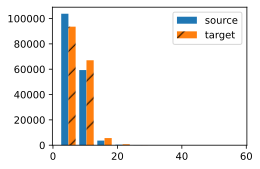

In [5]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

# Vocabulário

In [6]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

# Carregando o Conjunto de Dados

In [7]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]

In [8]:
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = tf.constant([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = tf.reduce_sum(
        tf.cast(array != vocab['<pad>'], tf.int32), 1)
    return array, valid_len

# Juntando todas as coisas

In [9]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [10]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', tf.cast(X, tf.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', tf.cast(Y, tf.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tf.Tensor(
[[ 78 158   7   4   5   5   5   5]
 [ 83  15   2   4   5   5   5   5]], shape=(2, 8), dtype=int32)
valid lengths for X: tf.Tensor([4 4], shape=(2,), dtype=int32)
Y: tf.Tensor(
[[ 47 188 179   7   4   5   5   5]
 [100 171   6   2   4   5   5   5]], shape=(2, 8), dtype=int32)
valid lengths for Y: tf.Tensor([5 5], shape=(2,), dtype=int32)


# 9.5.7 1

Para realizar os testes, foi criada uma função *test_vocab_sizes*, a qual executa a função *load_data_nmt* com diferentes valores para o parâmetro *num_examples* e retorna o tamanho dos vocabulários gerados. Por fim, um gráfico foi gerado relacionando o tamanho do vocabulário com o valor passado para o parâmetro.

In [11]:
# Função para realizar os testes com diferentes valores de num_examples
def test_vocab_sizes(num_examples_list):
    vocab_sizes = {'source_vocab': [], 'target_vocab': []}

    for num_examples in num_examples_list:
        _, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8, num_examples=num_examples)
        vocab_sizes['source_vocab'].append(len(src_vocab))
        vocab_sizes['target_vocab'].append(len(tgt_vocab))

    return vocab_sizes

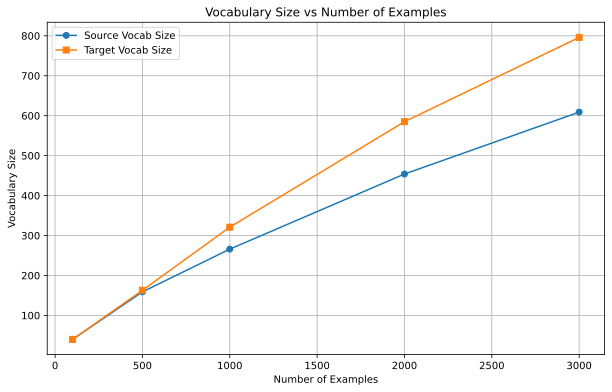

In [12]:
num_examples_list = [100, 500, 1000, 2000, 3000]
vocab_sizes = test_vocab_sizes( num_examples_list)

plt.figure(figsize=(10, 6))
plt.plot(num_examples_list, vocab_sizes['source_vocab'], label='Source Vocab Size', marker='o')
plt.plot(num_examples_list, vocab_sizes['target_vocab'], label='Target Vocab Size', marker='s')
plt.xlabel('Number of Examples')
plt.ylabel('Vocabulary Size')
plt.title('Vocabulary Size vs Number of Examples')
plt.legend()
plt.grid(True)
plt.show()


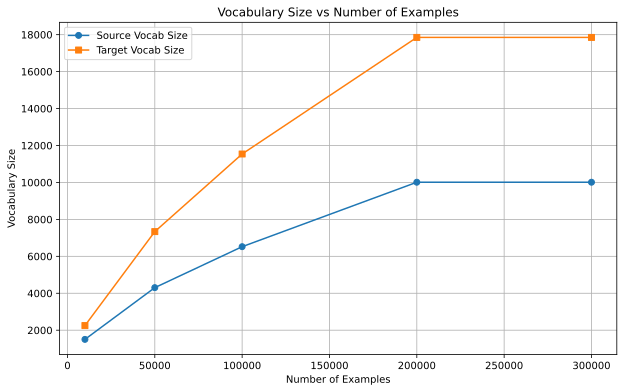

In [14]:
# Testes com valores maiores de num_examples
num_examples_list = [10000, 50000, 100000, 200000, 300000]
vocab_sizes = test_vocab_sizes( num_examples_list)

plt.figure(figsize=(10, 6))
plt.plot(num_examples_list, vocab_sizes['source_vocab'], label='Source Vocab Size', marker='o')
plt.plot(num_examples_list, vocab_sizes['target_vocab'], label='Target Vocab Size', marker='s')
plt.xlabel('Number of Examples')
plt.ylabel('Vocabulary Size')
plt.title('Vocabulary Size vs Number of Examples')
plt.legend()
plt.grid(True)
plt.show()


**Conclusão**

Os resultados mostram que tanto o vocabulário da língua de origem quanto o da língua de destino crescem com o aumento dos exemplos, e ambos atingem um ponto de estabilização. No entanto, o vocabulário da língua de destino cresce mais rapidamente antes de se estabilizar em um tamanho maior, enquanto o da língua de origem cresce de forma mais gradual e atinge uma estabilização em um tamanho de vocabulário menor.